##### Описание проекта
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Также необходимо проверить первичное предположение заказчика о возможности построения подобной системы на основе располагаемого пула данных, в частности, о возможности построения подобной модели по собранным данным о происшествиях.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMModel, LGBMClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,\
                            confusion_matrix, ConfusionMatrixDisplay,\
                            precision_recall_curve, PrecisionRecallDisplay

import warnings
warnings.filterwarnings("ignore")

PATH = './'

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

In [4]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM collisions
'''
df_collisions = pd.read_sql_query(query, con=engine)

query = '''
SELECT COUNT(DISTINCT id)
FROM parties
'''
df_parties = pd.read_sql_query(query, con=engine)

query = '''
SELECT COUNT(DISTINCT id)
FROM vehicles
'''
df_vehicles = pd.read_sql_query(query, con=engine)

In [5]:
display(df_collisions.values[0, 0])
display(df_parties.values[0, 0])
display(df_vehicles.values[0, 0])

1400000

2752408

1021234

In [6]:
query = '''
SELECT CASE_ID
FROM collisions
'''
df_collisions = pd.read_sql_query(query, con=engine)

query = '''
SELECT CASE_ID
FROM parties
'''
df_parties = pd.read_sql_query(query, con=engine)

query = '''
SELECT CASE_ID
FROM vehicles
'''
df_vehicles = pd.read_sql_query(query, con=engine)

In [7]:
display(df_collisions.head(3), df_collisions.nunique())
display(df_parties.head(3), df_parties.nunique())
display(df_vehicles.head(3), df_vehicles.nunique())

,case_id
0,4083072
1,4083075
2,4083073


case_id    1400000
dtype: int64

,case_id
0,3899454
1,3899454
2,3899462


case_id    1400000
dtype: int64

,case_id
0,5305032
1,3858022
2,5305030


case_id    792642
dtype: int64

##  Проведите статистический анализ факторов ДТП

### Количество аварий по месяцам

In [8]:
query = '''
SELECT to_char(collision_date::DATE, 'MONTH') as MONTH
FROM collisions
WHERE collisions.collision_damage != 'scratch' AND
    EXTRACT(YEAR FROM CAST(collisions.collision_date as timestamp)) = 2012
'''

df_collision_date = pd.read_sql_query(query, con=engine) 

In [9]:
new_order = ['January', 'February', 'March', 'April',\
             'May', 'June', 'July', 'August',\
             'September', 'October', 'November', 'December']
new_order = [i.upper() for i in new_order]

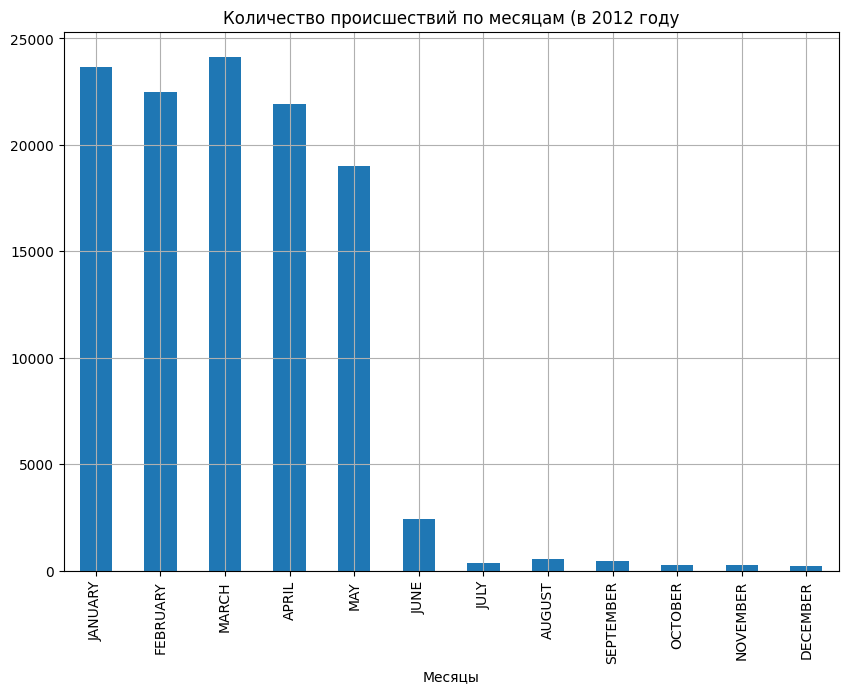

In [10]:
df_collision_date = df_collision_date.apply(lambda x: x[0].strip(), axis=1)
df_collision_date.value_counts(sort=False)\
                 .reindex(new_order)\
                 .plot(kind='bar',
                       title='Количество происшествий по месяцам (в 2012 году',
                       xlabel='Месяцы',
                       figsize=(10, 7),
                       grid=True)

plt.show()

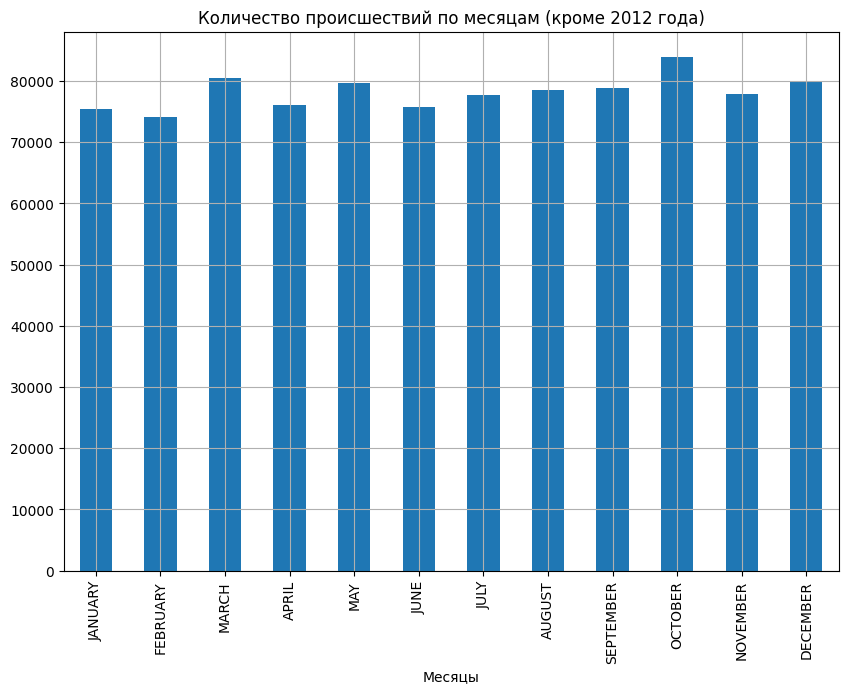

In [11]:
query = '''
SELECT to_char(collision_date::DATE, 'MONTH') as MONTH
FROM collisions
WHERE collisions.collision_damage != 'scratch' AND
    EXTRACT(YEAR FROM CAST(collisions.collision_date as timestamp)) != 2012
'''

df_collision_date = pd.read_sql_query(query, con=engine)

df_collision_date = df_collision_date.apply(lambda x: x[0].strip(), axis=1, )
df_collision_date.value_counts(sort=False)\
                 .reindex(new_order)\
                 .plot(kind='bar',
                       title='Количество происшествий по месяцам (кроме 2012 года)',
                       xlabel='Месяцы',
                       figsize=(10, 7),
                       grid=True)

plt.show()

Мы можем заметить, что количество инцидентов в 2012 году распределено по месяцам крайне неравномерно. При этом распределение количества инцидентов по другим годам выглядит куда более равномерным. В таком случае можно сделать следующие предположения:
 * часть данных утрачена или не подгружена(так как у нас все же присутствует информация  о происшествиях по всем месяцам просто не в достаточном объеме, то мы можем отсечь предположение о том, что на тот момент не было полной статистики по 2012 году);
 * использование месяца, сезона или квартала будет нерепрезентативной переменной.

Задачи:
* исследовать влияние районов города на риск аварии (влияние county_city_location на at_fault)
    * cоздайте sql-запрос;
    * проанализировать имеющиеся данные на возможность исполнения установленной задачи;
        * в случае наличия такой возможности - провести анализ, сделать выводы и визуализировать их;
        * иначе - проанализировать возможность иного представления имеющихся данных или иных источников данных для решения первоначальной задачи.
* исследовать время происшествия и риск аварии (влияние collision_time на at_fault)
* исследовать взимосвязь "состояний водителей" и районов города (влияние party_sobriety и party_drug_physical на county_city_location)
* исследовать взаимосвязь между серьезностью урона и размером страховки (влияние collision_damage и insurance_premium)
    * cоздайте sql-запрос;
    * проведите регрессионный анализ;
    * сделайте выводы и визуализируйте их.
* исследовать совместное влияние (мультиколлинеарность) погоды и освещения на риск аварии (совместное влияние WEATHER_1 и LIGHTING на at_fault)
* исследовать совместное влияние (мультиколлинеарность) погоды и дорожного состояния на риск аварии (совместное влияние WEATHER_1 и ROAD_CONDITION_1 на at_fault)

## Создайте модель для оценки водительского риска

#### Подготовка набора данных на основе первичного предположения заказчика

In [12]:
query = '''
SELECT *
FROM case_ids
JOIN vehicles on case_ids.case_id = vehicles.case_id
JOIN collisions on case_ids.case_id = collisions.case_id
RIGHT JOIN parties on case_ids.case_id = parties.case_id
WHERE parties.party_type = 'car' AND
      collisions.collision_damage != 'scratch' AND
      EXTRACT(YEAR FROM CAST(collisions.collision_date as timestamp)) = 2012
'''

df = pd.read_sql_query(query, con=engine)

In [13]:
display(df.head())
display(df.info())
display(df.describe())
display(df.duplicated().sum())

,case_id,db_year,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,5456472,2021,1328107,5456472,2,hatchback,auto,2.0,5456472,1941,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,improper turning,other,other object,dry,normal,daylight,functioning,2012-01-18,07:22:00,2409481,5456472,1,car,1,40.0,had not been drinking,None,0.0
1,5455082,2021,1326691,5455082,2,sedan,auto,2.0,5455082,1920,los angeles,150.0,east,0.0,clear,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,2012-01-05,17:11:00,2406821,5455082,1,car,1,20.0,had not been drinking,None,0.0
2,5462281,2021,1333845,5462281,2,sedan,manual,0.0,5462281,0700,contra costa,50.0,west,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-05,15:45:00,2420232,5462281,1,car,1,16.0,had not been drinking,None,0.0
3,5462281,2021,1333845,5462281,2,sedan,manual,0.0,5462281,0700,contra costa,50.0,west,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-05,15:45:00,2420233,5462281,2,car,0,40.0,had not been drinking,None,0.0
4,5468710,2021,1340314,5468710,2,sedan,auto,4.0,5468710,1900,los angeles,35.0,north,0.0,clear,None,small damage,4,vehicle code violation,improper turning,sideswipe,parked motor vehicle,dry,normal,daylight,none,2012-01-17,12:40:00,2432372,5468710,1,car,1,67.0,had not been drinking,None,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      118411 non-null  object 
 1   db_year                      118411 non-null  object 
 2   id                           118411 non-null  int64  
 3   case_id                      118411 non-null  object 
 4   party_number                 118411 non-null  int64  
 5   vehicle_type                 118411 non-null  object 
 6   vehicle_transmission         116545 non-null  object 
 7   vehicle_age                  115046 non-null  float64
 8   case_id                      118411 non-null  object 
 9   county_city_location         118411 non-null  object 
 10  county_location              118411 non-null  object 
 11  distance                     118411 non-null  float64
 12  direction                    89466 non-null   object 
 13 

None

,id,party_number,vehicle_age,distance,intersection,party_count,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,1.184110e+05,118411.000000,115046.000000,1.184110e+05,118043.000000,118411.000000,1.184110e+05,118411.000000,118411.000000,113289.000000,107507.000000
mean,1.429057e+06,1.681339,4.908263,7.320663e+02,0.234711,2.356487,2.594288e+06,1.647355,0.469686,38.624686,0.021320
std,5.452668e+04,0.784622,3.266265,6.902704e+03,0.423820,0.950973,9.899955e+04,0.812170,0.499082,16.355164,0.144448
min,9.855270e+05,1.000000,0.000000,0.000000e+00,0.000000,1.000000,1.800806e+06,1.000000,0.000000,0.000000,0.000000
25%,1.386167e+06,1.000000,3.000000,2.000000e+00,0.000000,2.000000,2.516794e+06,1.000000,0.000000,25.000000,0.000000
50%,1.431113e+06,2.000000,4.000000,1.180000e+02,0.000000,2.000000,2.597153e+06,1.000000,0.000000,36.000000,0.000000
75%,1.476229e+06,2.000000,7.000000,5.280000e+02,0.000000,3.000000,2.681314e+06,2.000000,1.000000,50.000000,0.000000
max,1.517654e+06,9.000000,161.000000,1.584000e+06,1.000000,10.000000,2.752388e+06,10.000000,1.000000,105.000000,1.000000


0

In [14]:
# удалим задублированные столбцы
# df = df.loc[:, ~df.columns.duplicated()]

In [15]:
columns = ['vehicle_age', # возраст автомобиля 
           # вероятно, может отражаться на исправности авто
           'county_city_location', # номер географических районов 
           # вероятно, существуют более склонные к авариям участки или районы
           'county_location', # названия географических районов 
           # как county_city_location, только другого уровня
           'distance', # расстояние от главной дороги 
           # косвенно может поведать нам о скоростном режиме и качестве дороги
           'direction', # направление движения 
           # не самый информативный критерий, но может раскрыться в купе, например, с county_city_location
           'intersection', # является ли место происшествие перекрёстком
           # особое условие происшествия
           'weather_1', # погода
           # погодные условия, очевидно, влияют на сложность управления авто
           'location_type', # тип дороги
           # особое условие происшествия (возможно мультиколлинеарность с intersection)
#            'collision_damage', # cерьёзность происшествия
#            # тип урона (cерьёзность происшествия)
#            'party_count', # количество участников
#            # количество участников дтп 
#            'primary_collision_factor', # основной фактор аварии
#            # posterior variable
#            'pcf_violation_category', # категория нарушения
#            # posterior variable
#            'type_of_collision', # тип аварии
#            # posterior variable
           'road_surface', # состояние дороги
           # влиет на аварийность - причем крайне нелинейно
           'road_condition_1', # дорожное состояние
           # особенности качественного состояние дороги
           'lighting', #освещение
           # качество освещения дороги звучит как значимый параметр
           'collision_date', # дата происшествия
           # можно извлечь значимые временные парметры как, например, номер недели или время года
           'collision_time', # время происшествия
           # можно извлечь данные, например, о времени суток
           'insurance_premium', #cумма страховки
           # размер страховой премии может влиять на манеру вождения или скрытые намерения водителя
           'party_sobriety', # трезвость участника
           # есть основания на необоснованное предположение о влиянии данного критерия на аварийность
           'party_drug_physical', # состояние участника: физическое или с учётом принятых лекарств
           # аналогично party_sobriety           
#            'cellphone_in_use', # наличие телефона в автомобиле (возможности разговаривать по громкой связи)
#            # наличие отвлекающего фактора в лице телефона
           'at_fault' # целевая переменная
]

df = df[columns]

#### EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vehicle_age           115046 non-null  float64
 1   county_city_location  118411 non-null  object 
 2   county_location       118411 non-null  object 
 3   distance              118411 non-null  float64
 4   direction             89466 non-null   object 
 5   intersection          118043 non-null  float64
 6   weather_1             118022 non-null  object 
 7   location_type         55137 non-null   object 
 8   road_surface          117645 non-null  object 
 9   road_condition_1      117843 non-null  object 
 10  lighting              118080 non-null  object 
 11  collision_date        118411 non-null  object 
 12  collision_time        118283 non-null  object 
 13  insurance_premium     113289 non-null  float64
 14  party_sobriety        116682 non-null  object 
 15  

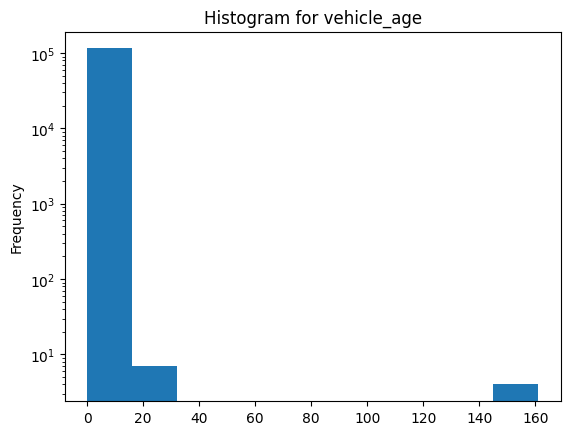

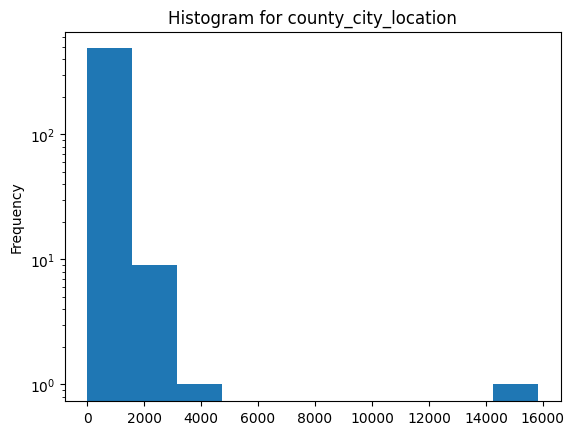

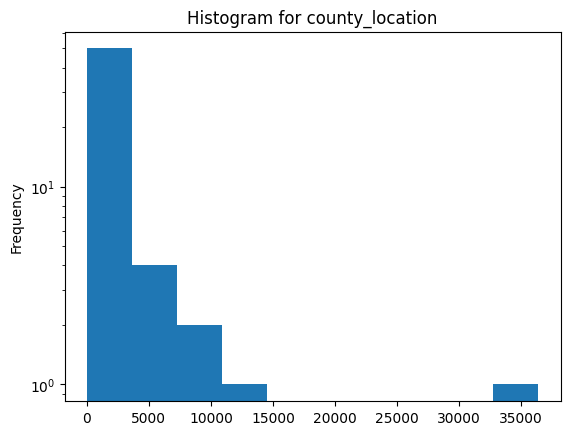

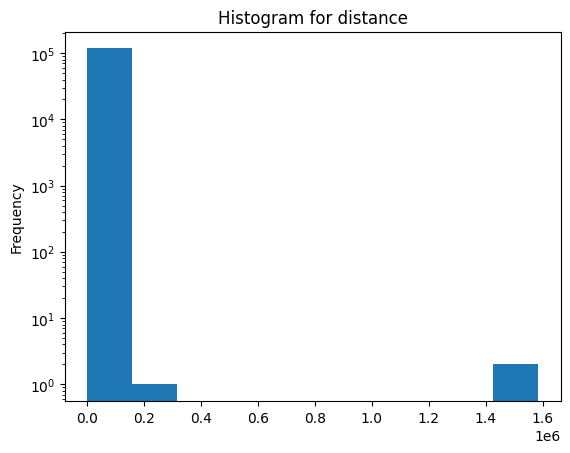

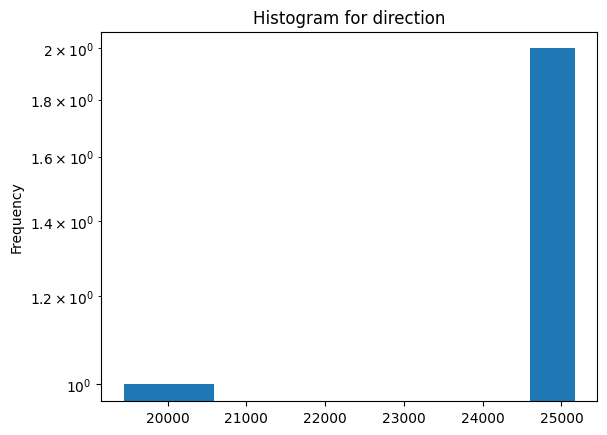

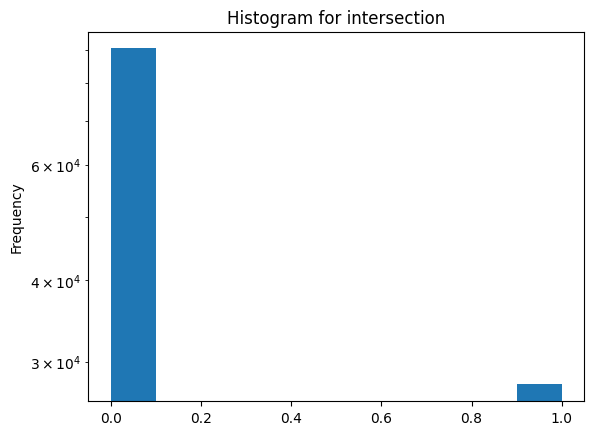

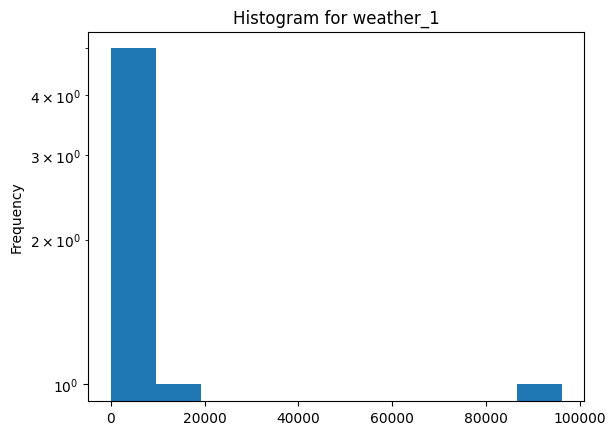

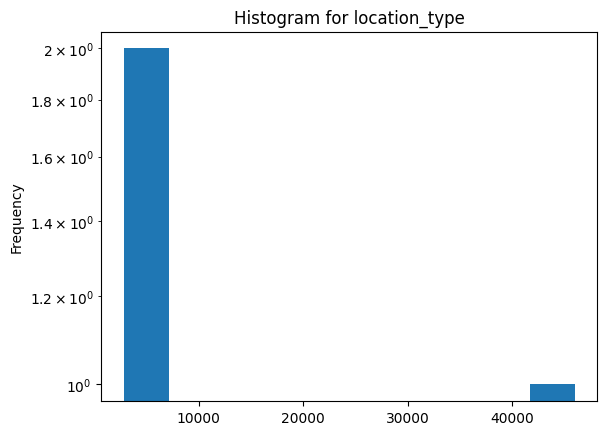

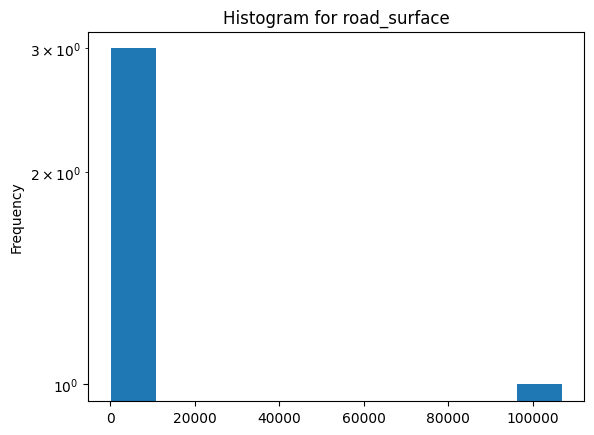

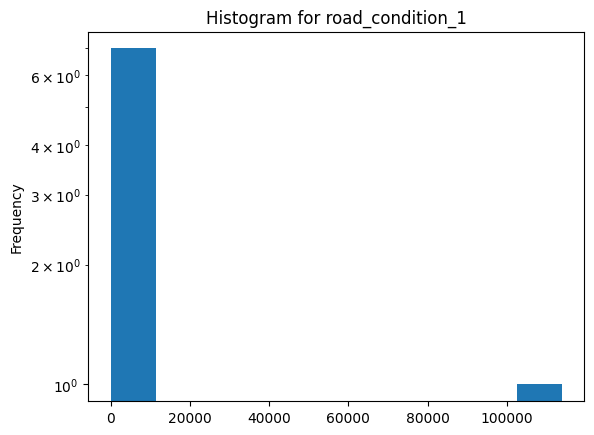

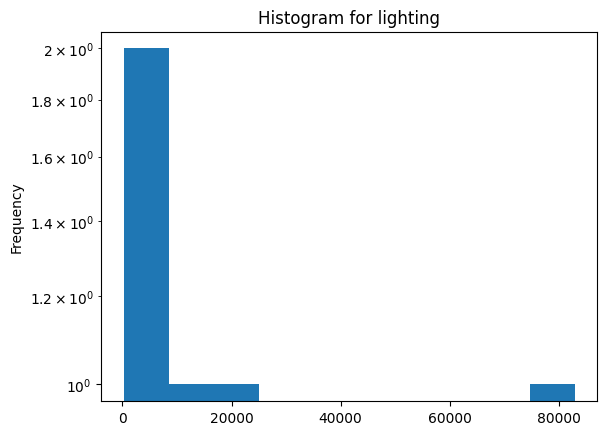

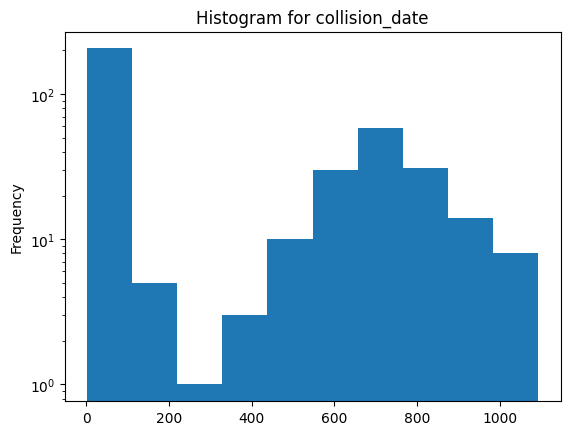

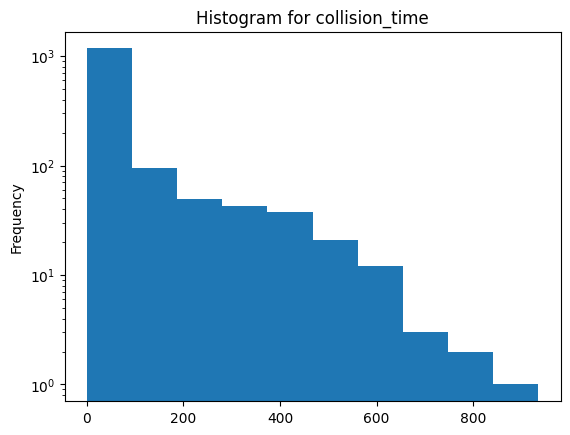

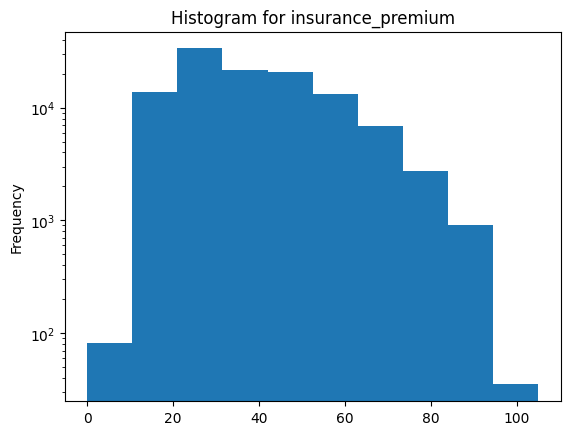

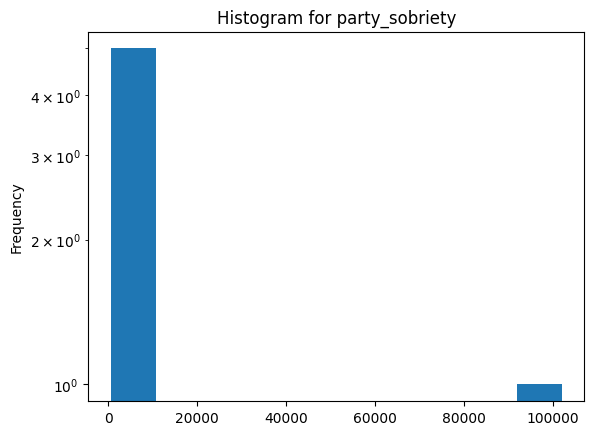

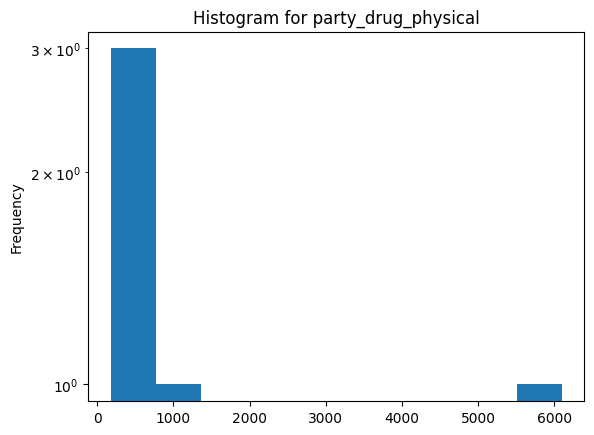

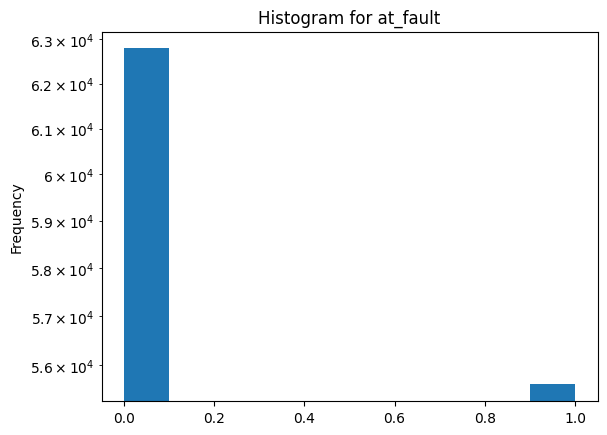

In [17]:
# использую логарифмическую шкалу, чтобы выбросы стали очевиднее
def plot_hists(df, use_log=True):
    for col in df.columns:
        if df[col].dtype in ['int', 'float']:
            plot_data = df[col]
        else:
            plot_data = df[col].value_counts()
        
        plot_data.plot(kind='hist',
                       xlabel=col,
                       title=f'Histogram for {col}')
        if use_log: plt.yscale('log')
        plt.show()

plot_hists(df)

In [18]:
# согласно гистограммам в vehicle_age действительно есть выбросы после ~30 лет
display(df.query('vehicle_age > 30'))
# а также в distance - после ~ 100 000
display(df.query('distance > 100000'))

df = df.query('vehicle_age <= 30')
df = df.query('distance <= 100000')

,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,collision_date,collision_time,insurance_premium,party_sobriety,party_drug_physical,at_fault
26180,161.0,1942,los angeles,449.0,north,0.0,clear,None,dry,normal,daylight,2012-06-20,11:45:00,18.0,had not been drinking,None,1
26182,161.0,1942,los angeles,449.0,north,0.0,clear,None,dry,normal,daylight,2012-06-20,11:45:00,53.0,had not been drinking,None,0
67566,161.0,1942,los angeles,0.0,None,1.0,clear,ramp,dry,normal,dusk or dawn,2012-12-05,05:55:00,42.0,had not been drinking,None,1
67568,161.0,1942,los angeles,0.0,None,1.0,clear,ramp,dry,normal,dusk or dawn,2012-12-05,05:55:00,22.0,had not been drinking,None,0


,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,collision_date,collision_time,insurance_premium,party_sobriety,party_drug_physical,at_fault
14093,3.0,3600,san bernardino,124080.0,west,0.0,clear,highway,dry,normal,dusk or dawn,2012-03-28,18:59:00,23.0,had not been drinking,None,1
75022,5.0,1400,inyo,171600.0,north,0.0,clear,None,dry,normal,daylight,2012-02-18,16:30:00,36.0,impairment unknown,G,1
108316,3.0,1942,los angeles,1584000.0,north,0.0,clear,highway,dry,normal,daylight,2012-05-22,15:45:00,63.0,had not been drinking,None,0
108317,3.0,1942,los angeles,1584000.0,north,0.0,clear,highway,dry,normal,daylight,2012-05-22,15:45:00,22.0,had not been drinking,None,1


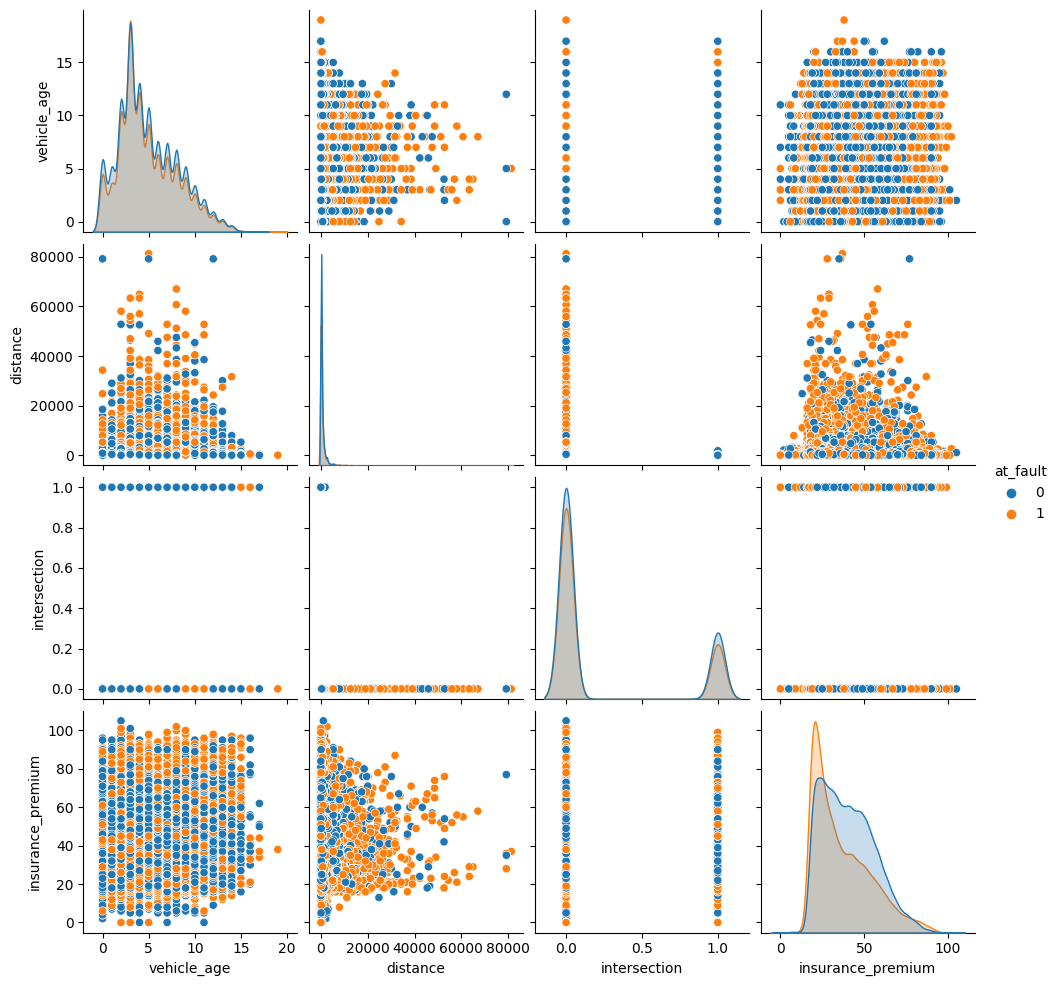

In [19]:
sns.pairplot(df, hue='at_fault')

#### Инжиниринг переменных и предобработка данных

In [20]:
# для простоты обозначим городские районы, встречающиеся реже 100 раз как other
ccl_vc = df.county_city_location.value_counts()
ccl_to_replace = ccl_vc[ccl_vc < 50].index
df['county_city_location'] = df['county_city_location'].replace(to_replace=ccl_to_replace, value='other')

In [21]:
# заменим na значения на other (будем рассматривать, как отдельную переменную)
na_category_cols = ['direction', 'location_type', 'party_drug_physical']
for col in na_category_cols: df[col].fillna('other', inplace=True)
df.dropna(axis=0, inplace=True)

In [22]:
# более масштабные параметры вроде номера недели, месяца, года и тп - не репрезентативны, так как данные
# неравномерны или неполные, поэтому возмем менее масштабные временные переменные
df['week_day'] = pd.to_datetime(df['collision_date']).dt.dayofweek
df['binned_hour'] = pd.cut(pd.to_datetime(df['collision_time'].astype(str)).dt.hour, 
                           bins=np.arange(0, 24+1, 3), include_lowest=True)

In [23]:
# разделение на тренировочную и тестовую выборки
num_cols = ['vehicle_age', 'distance', 'insurance_premium']
cat_cols = ['county_city_location', 'county_location', 'direction', 'intersection',
            'weather_1', 'location_type', 'road_surface', 'road_condition_1', 'lighting',
            'week_day', 'binned_hour', 'party_sobriety', 'party_drug_physical']

X = df[num_cols+cat_cols]
y = df['at_fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
col_trans = ColumnTransformer(transformers=[("nums", 'passthrough', num_cols),
                                            ("cats", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)], n_jobs=2)

# будем использовать "древесные" модели, поэтому обойдемся без масштабирования
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

#### Обучение моделей

In [25]:
model_types = {
               'adaboost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                                              random_state=42),
               'rndforest': RandomForestClassifier(random_state=42, n_jobs=-1),
               'lgb': LGBMClassifier(random_state=42, n_jobs=-1),
               'naive': DummyClassifier(strategy='stratified')
              }

models_params = {
                 'adaboost': {'n_estimators': [50, 75],
                              'learning_rate': [1.0, 0.01]},
                 'rndforest': {'n_estimators': [50, 75],
                           'max_depth': np.arange(10, 15+1, 5)},
                 'lgb': {'n_estimators': [50, 75],
                         'max_depth': np.arange(10, 15+1, 5),
                         'learning_rate' : [0.1, 0.01]},
                 'naive': {}
                }

In [26]:
%%time
# в качестве метрики выберем банальное accuracy - как метрику, которую можно интерпретировать как вероятностную.

def grid_search(model_types, models_params):
    best_models = {}
    cv_results = {}

    for model_type in model_types:
        model = model_types[model_type]
        grid = GridSearchCV(model, models_params[model_type], cv=5, scoring='accuracy',
                            n_jobs=5, refit=True, return_train_score=False)

        grid.fit(X_train, y_train)
        best_models[model_type] = grid.best_estimator_
        cv_results[model_type] = grid.cv_results_
        print('Лучшая модель в группе {} имеет значение accuracy - {:.2f} и параметры {}'\
              .format(model_type,\
                      grid.best_score_,\
                      grid.best_params_))
        print()
    return best_models, cv_results

best_models, cv_results = grid_search(model_types, models_params)

Лучшая модель в группе adaboost имеет значение accuracy - 0.64 и параметры {'learning_rate': 1.0, 'n_estimators': 75}

Лучшая модель в группе rndforest имеет значение accuracy - 0.65 и параметры {'max_depth': 15, 'n_estimators': 75}

Лучшая модель в группе lgb имеет значение accuracy - 0.65 и параметры {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 75}

Лучшая модель в группе naive имеет значение accuracy - 0.50 и параметры {}

CPU times: user 28.9 s, sys: 426 ms, total: 29.3 s
Wall time: 39.9 s


In [27]:
for model_type in cv_results:
    print(model_type)
    display(pd.DataFrame(cv_results[model_type])\
            [['mean_fit_time', 'mean_score_time', 'mean_test_score', 'params', 'rank_test_score']]\
            .sort_values('rank_test_score')
           )

adaboost


,mean_fit_time,mean_score_time,mean_test_score,params,rank_test_score
1,4.144004,0.147598,0.641881,"{'learning_rate': 1.0, 'n_estimators': 75}",1
0,2.808995,0.098980,0.641647,"{'learning_rate': 1.0, 'n_estimators': 50}",2
2,2.800488,0.098141,0.600690,"{'learning_rate': 0.01, 'n_estimators': 50}",3
3,4.185495,0.125533,0.600690,"{'learning_rate': 0.01, 'n_estimators': 75}",3


rndforest


,mean_fit_time,mean_score_time,mean_test_score,params,rank_test_score
3,3.773704,0.215765,0.654586,"{'max_depth': 15, 'n_estimators': 75}",1
2,2.347784,0.251919,0.653556,"{'max_depth': 15, 'n_estimators': 50}",2
0,2.465362,0.116920,0.646186,"{'max_depth': 10, 'n_estimators': 50}",3
1,3.475115,0.375978,0.646128,"{'max_depth': 10, 'n_estimators': 75}",4


lgb


,mean_fit_time,mean_score_time,mean_test_score,params,rank_test_score
3,0.408479,0.032330,0.646724,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 75}",1
0,0.291547,0.024081,0.646303,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}",2
1,0.404822,0.031110,0.646116,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 75}",3
2,0.320544,0.022610,0.645905,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 50}",4
7,0.445273,0.027834,0.642279,"{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 75}",5
5,0.449956,0.028402,0.642232,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 75}",6
4,0.335395,0.020796,0.639331,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50}",7
6,0.350058,0.019751,0.639120,"{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 50}",8


naive


,mean_fit_time,mean_score_time,mean_test_score,params,rank_test_score
0,0.007322,0.00237,0.500643,{},1


Откровенно говоря, лучшие модели в классе демонстрируют приблизительно одинаковую результативность, поэтому в целом окончательный выбор не столь принципиален. Для дальнейего рассмотрения остановимся на RandomForest'е.

In [28]:
preds = best_models['rndforest'].predict(X_test)
display(accuracy_score(y_test, preds))

0.6579008937345

## Проведите анализ важности факторов ДТП

precision - 0.71658615136876, recall - 0.41152897657213316


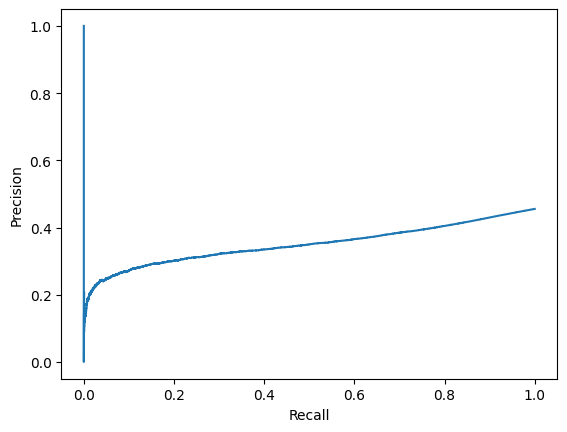

In [29]:
proba_preds = best_models['rndforest'].predict_proba(X_test)[:, 0]

precision, recall, _ = precision_recall_curve(y_test, proba_preds, )
print(f'precision - {precision_score(y_test, preds)}, recall - {recall_score(y_test, preds)}')
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

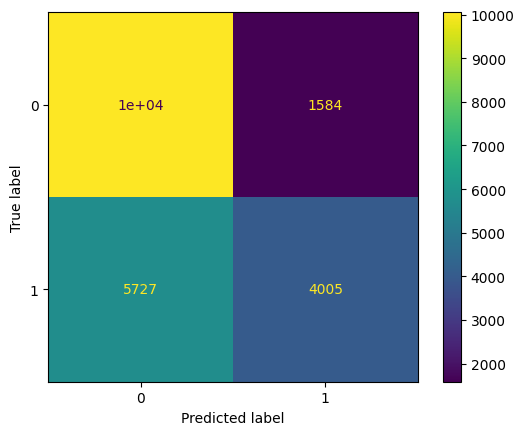

In [30]:
conf_matrix = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, )
disp.plot()
plt.show()

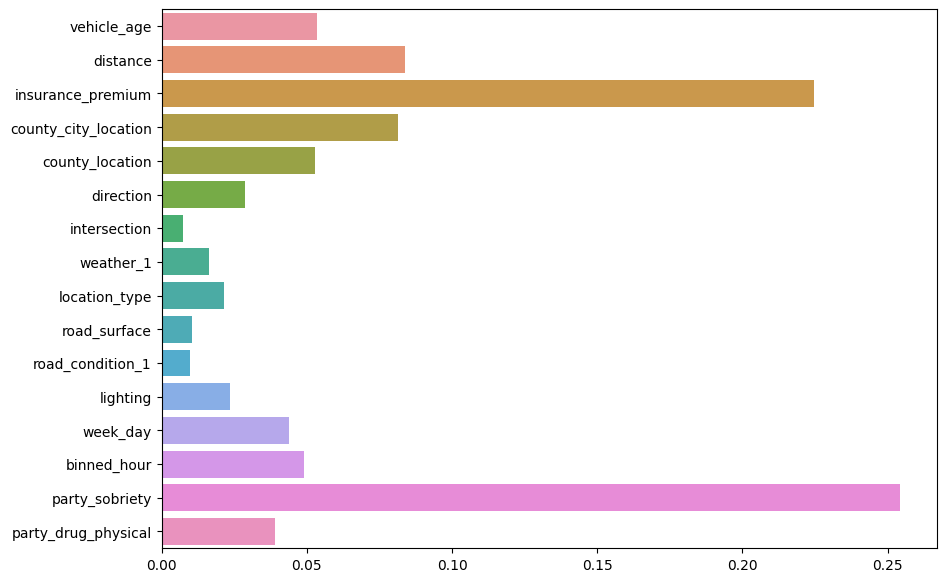

array([[ 1.        , -0.10857826],
       [-0.10857826,  1.        ]])

In [31]:
plot_data = pd.Series(best_models['rndforest'].feature_importances_, index=X.columns)



plt.figure(figsize=(10, 7))
sns.barplot(x=plot_data, y=plot_data.index)
plt.show()

display(np.corrcoef(df['insurance_premium'], df['at_fault']))

Раз уж пример с трезвостью уже был рассмотрен, то мы рассмотрим параметр insurance_premium (cумма страховки). Древесные модели не так легко интерпретировать как линейные - неочевидно наличие положительной или отрицательной зависимости. Однако они способны отражать более сложные зависимости. И если в случае с "трезвостью" зависимость более интуитивно уловима, то в примере со страховкой все может показаться куда более сложным. Однако так как "страховая премия" не категориальный признак - то, чтобы прояснить наше интуитивное понимание мы можем прибегнуть к поиску линейной взаимосвязи. Как мы можем видеть - коэффициент корреляции отрицателен, но весьма не высок по модулю, и при этом мы видим, что в нашей модели этот параметр весьма существеннен. Тут мы можем лишь косвенно подтвердить наши догадки о сложной нелинейной взаимозависимости, особенности которой мы попробуем предположить ниже:
 * нет информации о юридических особенностях страхования. например, если есть обязательный уровень страхования, но респондент страхует автомобиль на большую сумму, то это может косвенно свидетельствовать о его повышенном внимании к автомобилю и, как следствие, более безопасной езде. при этом, если респонденту с более высокой исторической склонностью с авариям необходимо оплачивать более высокую обязательную страховую премию, то сам размер страховой премии может характеризовать индивидуальную склонность репондента к аварийному вождению;
 * размер страховой премии косвенно может отражать рыночную стоимость автомобиля и его исправность;
 * респонденты как рациональные экономические агенты с нерациональной любовью к небезопасному вождению, склонны тратить на страхование больше средств, потому что знают о возможных негативных последствиях.
 
Впрочем даже если неочевидная природа взаимосвязи между данными показателями может быть постигнута не до конца или не определена в рамках данного проекта - общая рекомендация заказчику будет общей.
Страховые организации имею доступ к таким частным характеристикам страхователей как история ДТП, общий стаж и т.д.
Указанные данные, в частности, об истории ДТП с участием данного клиента в качестве виновника могут существенно влиять на вероятность попадания респондента в ДТП или просто фиксацию факта небезопасного вождения. В таком случае, представляется целесообразным прибегнуть к частным случаям экономической дискриминации, таким как:
 * повышение цены предоставляемых услуг;
 * повышение залоговых обязательств клиента;
 * просьба к "следующим" клиентам более тщательно осматривать автомобили на наличие повреждений.

## Выводы

В выводах хотелось бы вернуться к первоначальной задаче проекта - разработка системы, которая могла бы оценить риск ДТП по выбранному маршруту движения. То есть по затронутым в размках построения маршрута дорогам, районам, развязкам дать определение аварийности маршрута. Для начала просто рассмотрим статистические данные аварийности по райном

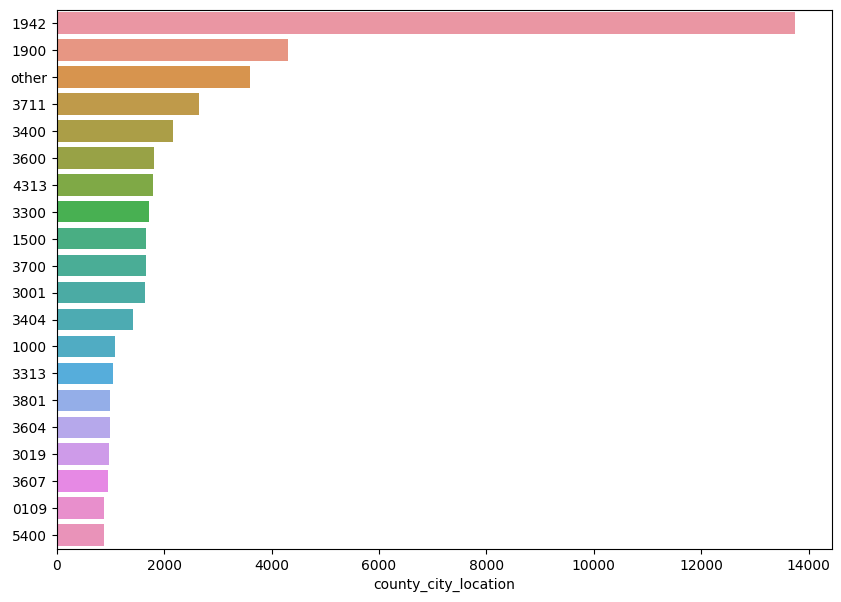

In [32]:
# количество "автомобильных инцидентов" по районам
plot_data = pd.Series(X.county_city_location.value_counts())[:20]

plt.figure(figsize=(10, 7))
sns.barplot(x=plot_data, y=plot_data.index)
plt.show()

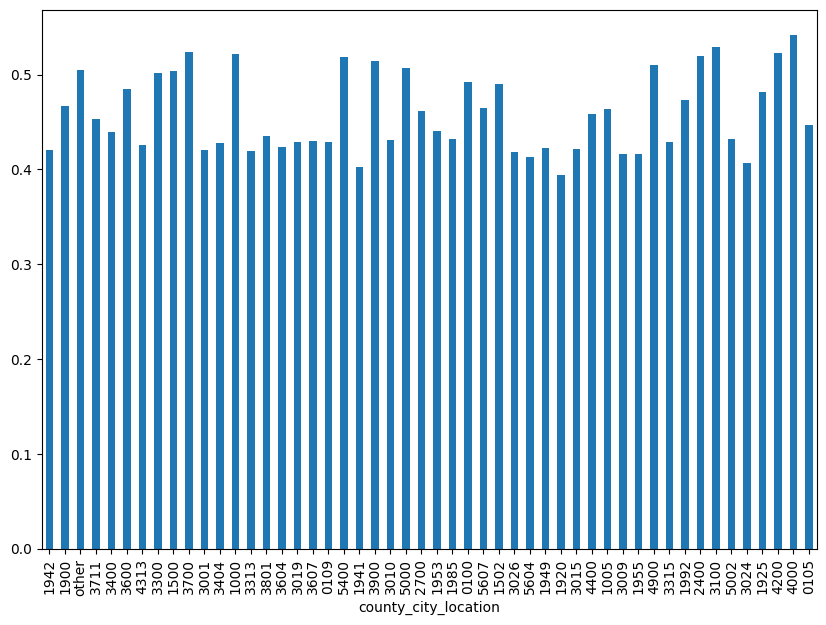

In [33]:
# средняя "аварийность" по районам
df.groupby(['county_city_location'])['at_fault']\
  .agg(['mean', 'count'])\
  .sort_values('count', ascending=False)[:50]['mean']\
  .plot(kind='bar', figsize=(10, 7))

plt.show()

По указанным данным складывается впечатление о том, что вероятностная оценка попадания в аварию невероятно высока - что противоречит интуииции. Поэтому представлется целесообразным вернуться к вопросу адекватности имеющихся данных для оценки такого параментра как аварийность или риск аварии. По условию задания у нас есть набор инцидентов - не столько важно виновен участник или нет. Сами инциденты - достаточно редкие события и безусловно несут в себе полезную информацию, но в отрыве от остально пула, от, скажем так, "неинцидентов" - мы рискуем делать необоснованные предположения, и, что куда хуже - делать ложнообоснованные выводы. С такми же успехом, мы можем ввести параметр "наличие глаз у водителя" и утверждать, что люди с глазами попадают в аварийные ситуации почти в 50% случаев. 

Более того, несбалансированность нашей выборки также обесценивает влияние возможных значимых переменных, так как в большинстве аварий учавствуют 2 транспортных средства с условными "виновником" и "невиновником", но при этом они оба действуют в одинаковых условиях внешней среды. То есть возможные значимые переменные имеют одинаковые значения в "успешных" и "неуспешных" испытаниях. Но будь у нас полная информация о пассажиропотоках мы могли бы заметить, что, например, дожди или плохоасфальтированные дороги повышают аварийность. Таким образом, факторы внешней среды теряют информативность.

Указанное выше в некоторой степени также относится и к факторам, характеризующим самого водителя. Если отбросить наше интуитивное представление о том, что алкогольное опъянение повышает риск аварийности на доргах, - то нам стоило бы провести проверку гипотезы об указанном. Например, сравнить в достаточно большой выборке - а действительно ли люди в алкогольном опъянении более рисковые клиенты? Может ли так оказаться, что в некоторых случаях - люди в алкогольном опъянении ездят со скоростью в 20 км/ч, зная о действии алкоголя на их нервную системы? Более того, информативных факторов, описывающих водителя крайне мало, а в купе с вышеуказанной проблемой (малоинформативность факторов внешней среды), модель пытается выжать из них все. Именно поэтому такие факторы как "размер страховки" и "алкогольное опъянение" столь значимы.

Отвечая на главный вопрос проекта - о возможности прогнозирования рискованности маршрута, могу лишь отметить, что в рамках представленной информации подобный анализ выглядит малоперспективным и требует совершенно другого подхода к подготовке исходных данных для прогнозирования (в том числе данные клиентов каршеринга с историями ДТП, данные о пассажиропотоках, наличии "центров притяжения").